In [0]:
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [0]:
labels = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

In [0]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRL5xP3Fmdwe8xlah-W3PqwyjtzZGHWKlFI7PPSVTbtyG7t_e-1 -O test.png

--2020-01-31 04:04:39--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRL5xP3Fmdwe8xlah-W3PqwyjtzZGHWKlFI7PPSVTbtyG7t_e-1
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 108.177.119.100, 108.177.119.113, 108.177.119.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|108.177.119.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45095 (44K) [image/jpeg]
Saving to: ‘test.png’

test.png            100%[===================>]  44.04K  --.-KB/s    in 0s      

2020-01-31 04:04:39 (126 MB/s) - ‘test.png’ saved [45095/45095]



In [0]:
img = Image.open("./test.png")

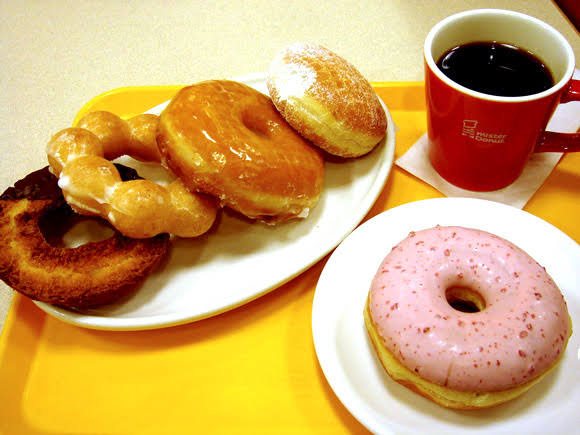

In [13]:
img

In [14]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s]


In [0]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
tensor_img = transform(img).unsqueeze(0)

In [22]:
tensor_img.shape

torch.Size([1, 3, 224, 224])

In [0]:
grad = None

def gradient_hook(g):
    print('gradient hook')
    global grad
    grad = g

In [0]:
x = tensor_img

for name, module in model.named_children():
    if name == 'classifier':
        x = x.view(x.size(0), -1)
    x = module(x)
    if name == 'features':
        x.register_hook(gradient_hook)
        feature = x

In [67]:
out = F.sigmoid(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [68]:
out.shape

torch.Size([1, 1000])

In [0]:
out_max, _ = out.max(dim=-1)

In [70]:
out_max.shape

torch.Size([1])

In [71]:
out_max

tensor([1.0000], grad_fn=<MaxBackward0>)

In [0]:
model.zero_grad()

In [73]:
out_max.backward()

gradient hook


In [74]:
grad.shape

torch.Size([1, 512, 7, 7])

In [0]:
weight = grad.mean(dim=(-1, -2), keepdim=True)

In [148]:
weight.shape

torch.Size([1, 512, 1, 1])

In [0]:
mask = F.relu((weight * feature).sum(dim=1)).squeeze(0)

In [182]:
mask.shape

torch.Size([7, 7])

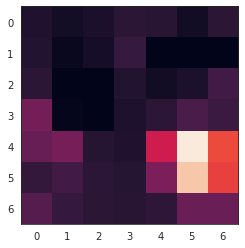

In [183]:
plt.imshow(mask.detach().numpy())

In [0]:
mask = cv2.resize(mask.detach().numpy(), (tensor_img.shape[-1], tensor_img.shape[-2]))

mask = mask - np.min(mask)
if np.max(mask) != 0:
    mask = mask / np.max(mask)

In [185]:
mask.shape

(224, 224)

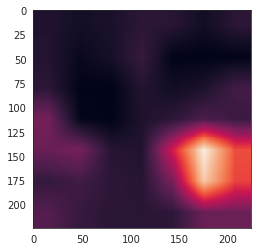

In [186]:
plt.imshow(mask)

In [0]:
mask = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))

In [0]:
masked_img = mask + np.float32((np.uint8(tensor_img[0].permute((1, 2, 0)) * 255)))
masked_img = masked_img - np.min(masked_img)

if np.max(masked_img) != 0:
    masked_img = masked_img / np.max(masked_img)

In [164]:
cam.shape

(224, 224, 3)

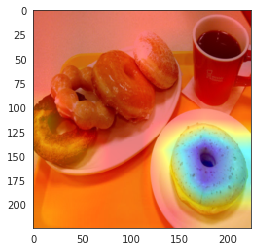

In [165]:
plt.imshow(cam)

In [170]:
torch.argmax(model(tensor_img))

tensor(931)

In [171]:
labels[931]

'bagel, beigel'